In [1]:
#pip install mlxtend

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [64]:
data = pd.read_csv("brca_vs_normal.csv")

In [83]:
data['center'].value_counts()

Washington University School of Medicine              199
University of North Carolina                           65
Harvard Medical School                                 38
MD Anderson - Institute for Applied Cancer Science      2
Name: center, dtype: int64

# Building and Comparing Models
## Performing Leave-One-Group-Out Cross-Validation (LOGO-CV) or Batch Effect Validation

Training on Center University of North Carolina - Accuracy on other centers: 0.49
Training on Center University of North Carolina - AUC score = 0.50
Training on Center Washington University School of Medicine - Accuracy on other centers: 0.73
Training on Center Washington University School of Medicine - AUC score = 0.77
Training on Center Harvard Medical School - Accuracy on other centers: 0.64
Training on Center Harvard Medical School - AUC score = 0.67


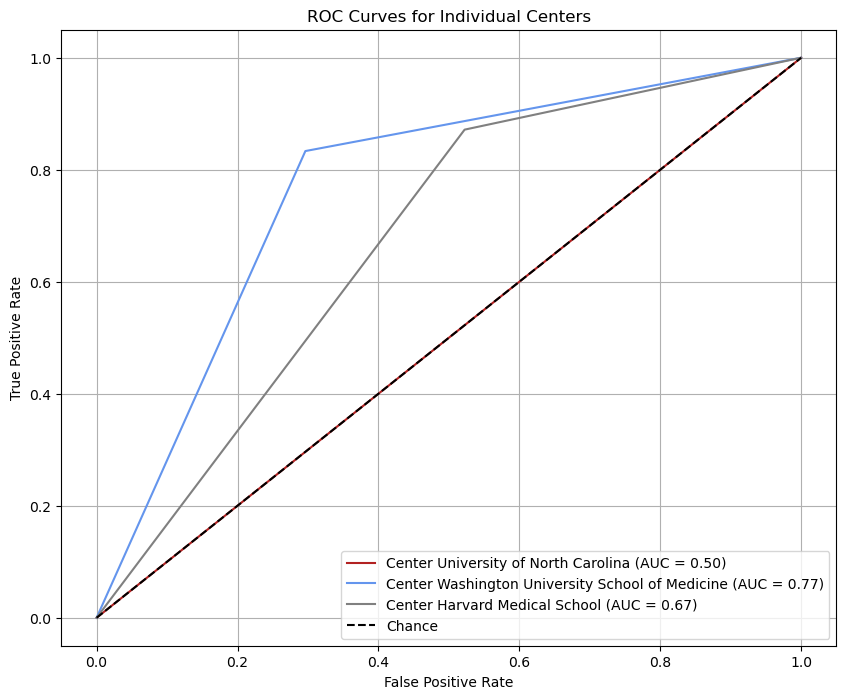

In [82]:
# Encode sample_type as numeric
data['sample_type'] = LabelEncoder().fit_transform(data['sample_type'])

# Defining features and target
X = data.drop(columns=['sample_type'])
y = data['sample_type']
groups = data['center']  # Use 'center' as the grouping column

# Unique centers
unique_centers = groups.unique()
unique_centers = unique_centers[0:3] #removing MD Anderson as a center since it has only 2 data points and the model needs more data points

accuracies = []
aucs = {}
rocs = {}

# Perform one-group-train, rest-test validation based on 'center'
for center in unique_centers:
    # Train on one center, test on the rest
    train_idx = groups == center
    test_idx = ~train_idx

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    X_train = X_train.iloc[: , 0:294]
    X_test = X_test.iloc[:, 0:294]
    
    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions and calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Training on Center {center} - Accuracy on other centers: {accuracy:.2f}")

    auc = roc_auc_score(y_test, y_pred)
    aucs[center] = auc
    print(f"Training on Center {center} - AUC score = {auc:.2f}")
    
    fpr,tpr,threshols = roc_curve(y_test, y_pred)
    rocs[center] = (fpr, tpr)

colors = {'University of North Carolina': "firebrick",
          'Washington University School of Medicine': "cornflowerblue", 
          'Harvard Medical School': "grey"}
    
plt.figure(figsize=(10, 8))
for center, (fpr, tpr) in rocs.items():
    plt.plot(fpr, tpr, label=f'Center {center} (AUC = {aucs[center]:.2f})', color = colors[center])

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Individual Centers")
plt.legend(loc='lower right')
plt.grid()
plt.savefig("RandonForest_BRCAvsNormal.png")
plt.show()

## Testing on the Two Centers that have Equal Representation of Controls and Cases
Removing MD Anderson and Harvard Medical School from the centers.

Models: Random Forest does a little better.

In [54]:
data = pd.read_csv("brca_vs_normal.csv")
dataFiltered = data[(data['center'] == "University of North Carolina") | 
                    (data['center'] == "Washington University School of Medicine")]

Accuracy on 20% test set: 0.68
AUC score = 0.64


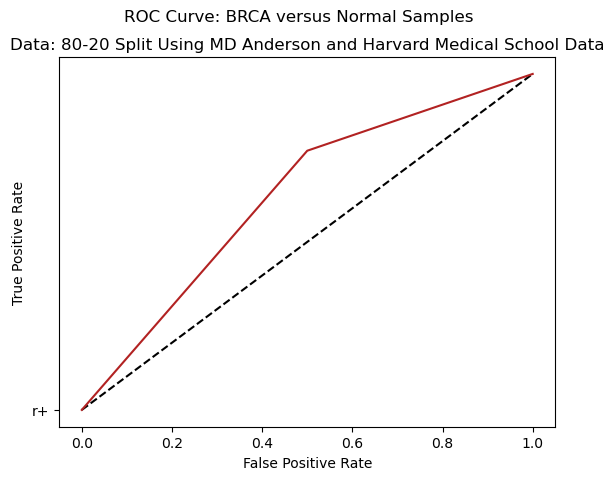

In [55]:
X = dataFiltered.drop(columns=['sample_type', 'center'])
y = dataFiltered['sample_type']
y = y.map({'normal': 0, 'brca': 1}).astype(int)

# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#y_test = y_test.map({'normal': 0, 'brca': 1}).astype(int)


# Initialize and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on 20% test set: {accuracy:.2f}")

auc = roc_auc_score(y_test, y_pred)
print(f"AUC score = {auc:.2f}")

fpr,tpr,threshols = roc_curve(y_test, y_pred, pos_label=1)

plt.plot([0,1],[0,1],"k--",'r+')
plt.plot(fpr,tpr,label='Random Forest', color='firebrick')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Data: 80-20 Split Using MD Anderson and Harvard Medical School Data")
plt.suptitle("ROC Curve: BRCA versus Normal Samples")
plt.savefig("RandomForest_MDAnd&Harvard.png")

plt.show()

# BRCA versus Other Cancers
Model: Random Forest does a little better.

Result: The result tells us, BRCA has a specific microbiome associated with it, that can help differentiate from other cancer types.

In [9]:
#pip install imbalanced-learn
#!pip install scikit-learn==1.2.2
#!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)


In [1]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

In [57]:
dataBrcaVsOthers = pd.read_csv("brca_vs_others.csv")
dataBrcaVsOthers['disease_type'] = LabelEncoder().fit_transform(dataBrcaVsOthers['disease_type'])
#0 - BRCA
#1 - Others

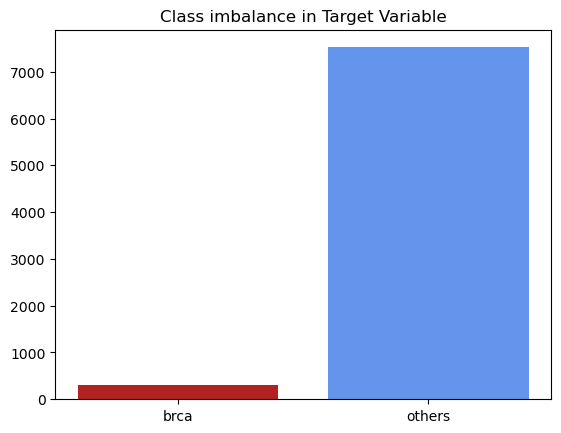

In [58]:
ax = plt.axes() 
bvoCounts = dataBrcaVsOthers['disease_type'].value_counts()
plt.bar(bvoCounts.index, 
        bvoCounts.values, 
        color = ['cornflowerblue', 'firebrick'])
ax.set_xticks([0,1]) 
ax.set_xticklabels(['brca', 'others'])
plt.title('Class imbalance in Target Variable')
plt.savefig('brcavothersCounts.png')

In [6]:
#dataBrcaVsOthers['disease_type'].value_counts()

In [59]:
X = dataBrcaVsOthers.drop(columns=['disease_type'])
y = dataBrcaVsOthers['disease_type']
X.set_index('sampleid', inplace=True)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

1    6017
0    6017
Name: disease_type, dtype: int64


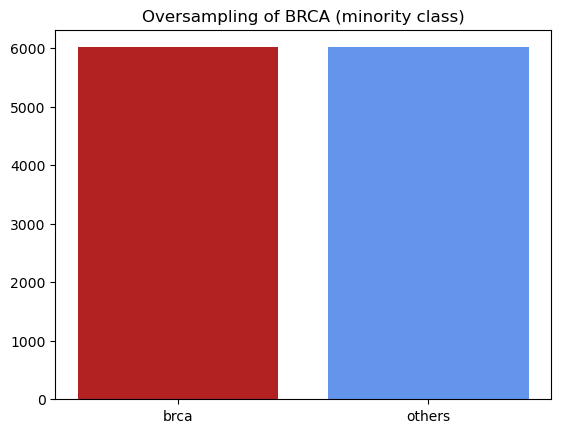

In [61]:
#Random oversampling only on the training dataset
randOver = RandomOverSampler(random_state=111)
X_ros, y_ros = randOver.fit_resample(X_train, y_train)

rosCounts = y_ros.value_counts()
print(rosCounts)

ax = plt.axes() 
plt.bar(rosCounts.index, 
        rosCounts.values, 
        color = ['cornflowerblue', 'firebrick'])
ax.set_xticks([0,1]) 
ax.set_xticklabels(['brca', 'others'])
plt.title('Oversampling of BRCA (minority class)')
plt.savefig('OversampleBRCA.png')

Accuracy on 20% test set: 0.93
AUC score = 0.76


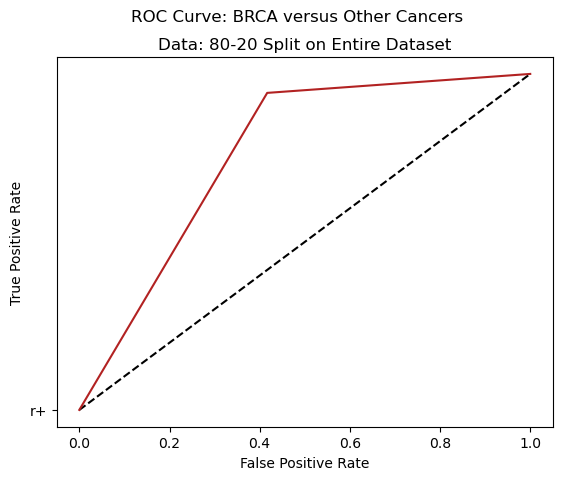

In [62]:
# Initialize and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_ros, y_ros)

# Make predictions and calculate accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy on 20% test set: {accuracy:.2f}")

fpr,tpr,threshols = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print(f"AUC score = {auc:.2f}")

plt.plot([0,1],[0,1],"k--",'r+')
plt.plot(fpr,tpr,label='Random Forest', color='firebrick')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.suptitle("ROC Curve: BRCA versus Other Cancers")
plt.title("Data: 80-20 Split on Entire Dataset")
plt.savefig("RandomForest_BRCAversusOthers.png")
plt.show()